In [429]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
from pathlib import Path
import openpyxl

In [430]:
# コピー元のパス・シート指定
file_path = Path(Path.home(), "DataFile", "testDataFile.xlsx")
#sheet_name_list = ["J1 (50MPa) (金型修正用)", "J1 (50MPa) (2)", "J2（60MPa)", "J2（60MPa)"]
sheet_name_list = ["J1 (50MPa) (金型修正用)", "J1 (50MPa) (2)", "J2（60MPa)"]
#sheet_name_list = ["J1 (50MPa) (金型修正用)", "J1 (50MPa) (2)"]

In [436]:
# xlsxファイルの読み込みとデータ整理
#元データ
original_df = pd.read_excel(file_path,sheet_name=sheet_name_list, skiprows=7, \
skipfooter=45, header=[0,1,2,3], index_col = 1)

#dictをリスト化&要らない列を削除
original_dfs = [original_df[sheet_name_list[sheet_number]].drop(('Unnamed: 0_level_0',\
'Unnamed: 0_level_1', 'Unnamed: 0_level_2', 'Unnamed: 0_level_3'), axis=1) \
for sheet_number in range(len(sheet_name_list))]

#df内の空白列を削除
for sheet_number in range(len(sheet_name_list)):
    original_dfs[sheet_number].dropna(how="all",axis=1, inplace=True)

#Multiple columnsをmargeしてoriginal_dfsを再定義
for sheet_number in range(len(sheet_name_list)):
    columns_integer = "Dim"
    columns_marge = [None] * len(original_dfs[sheet_number].columns)  # 47に相当するカラム数に合わせてリストを初期化

    for i in range(len(original_dfs[sheet_number].columns)):
        for j in range(4):
            if  "Unnamed" not in str(original_dfs[sheet_number].columns[i][j]) :
                columns_integer += "_" + str(original_dfs[sheet_number].columns[i][j])
        columns_marge[i] = columns_integer
        columns_integer = "Dim"

    for i in range(len(columns_marge)):
        columns_marge[i] = columns_marge[i].replace("/", "per")
        columns_marge[i] = columns_marge[i].replace(".", "")

    columns_marge[46]=columns_marge[46].replace(columns_marge[46],"Weight") #最後だけ手動で置き換え・・・


    original_dfs[sheet_number] = pd.DataFrame(original_dfs[sheet_number].values, \
    index = original_dfs[sheet_number].index, columns = columns_marge)

In [437]:
#sampleデータのdf
sample_dfs = [original_dfs[sheet_number].drop(['Nominal', 'Up Tol.', 'Low Tol.']) for sheet_number in range(len(sheet_name_list))]

#寸法と公差のdf
dimension_dfs = [original_dfs[sheet_number].copy().head(3) for sheet_number in range(len(sheet_name_list))]

In [438]:
# 統計量等のdf
statistics_dfs = []

for sdf, ddf in zip(sample_dfs, dimension_dfs):
    stats_df = pd.DataFrame()
    stats_df["Average"] = sdf.mean() #n30平均値
    stats_df["Max_sample"] = sdf.max() #n30最大値
    stats_df["Min_sample"] = sdf.min() #n30最小値
    stats_df["Sigma"] = sdf.std() #n30標準偏差
    stats_df["Upper_Limit"] = ddf.loc["Nominal"] + ddf.loc["Up Tol."] #最大寸法
    stats_df["Lower_Limit"] = ddf.loc["Nominal"] + ddf.loc["Low Tol."] #最小寸法

    stats_df["Center_Line"] = (stats_df["Upper_Limit"] + stats_df["Lower_Limit"])/2 #中央寸法
    stats_df["Process_Capability_Index"] = (stats_df["Upper_Limit"]\
    - stats_df["Lower_Limit"])/(6*stats_df["Sigma"]) #プロセス能力指数
    stats_df["Ave+3Sigma"] = stats_df["Average"] + 3*stats_df["Sigma"]#n30平均値+3Sigma
    stats_df["Ave-3Sigma"] = stats_df["Average"] - 3*stats_df["Sigma"]#n30平均値-3Sigma
    stats_df["Difference"] = stats_df["Max_sample"] - stats_df["Min_sample"] #n30最大-最小

    # 統計量(Cpk)行をstat_dfに追加, where構文で条件づけてデータを追加する
    upperCPk = (stats_df["Upper_Limit"] - stats_df["Average"])/(3*stats_df["Sigma"])
    lowerCPk = (stats_df["Average"] - stats_df["Lower_Limit"])/(3*stats_df["Sigma"])
    Cpk = upperCPk.where(upperCPk < lowerCPk, lowerCPk)
    stats_df["Cpk"] = Cpk

    statistics_dfs.append(stats_df)

In [439]:
#エクセルに転記するdf
pre_export_dfs=[]

for df in statistics_dfs:
    pre_ex_df = pd.DataFrame()
    pre_ex_df = df[["Cpk", "Sigma", "Upper_Limit", "Lower_Limit", "Average",\
"Max_sample", "Min_sample", "Ave+3Sigma", "Ave-3Sigma"]].T

    pre_export_dfs.append(pre_ex_df)


# 各シートの各列ごとにdfを並べ替える.
input_column_name = ["a", "b", "c", "d"] #列名を決める
export_dfs=[]

for column_name in columns_marge:
    ex_df = pd.concat([df[column_name] for df in pre_export_dfs], axis= 1)
    ex_df.columns = [input_column_name[i] for i in range(len(pre_export_dfs))]
    export_dfs.append(ex_df)


#plotするdf
pre_plot_dfs=[]

for df in statistics_dfs:
    pre_plt_df = pd.DataFrame()
    pre_plt_df = df[["Upper_Limit", "Lower_Limit", "Average",\
"Max_sample", "Min_sample", "Ave+3Sigma", "Ave-3Sigma"]].T

    pre_plot_dfs.append(pre_plt_df)

# 各シートの各列ごとにdfを並べ替える.
plot_dfs=[]

for column_name in columns_marge:
    plot_df = pd.concat([df[column_name] for df in pre_plot_dfs], axis= 1)
    plot_df.columns = [input_column_name[i] for i in range(len(pre_plot_dfs))]
    plot_dfs.append(plot_df)

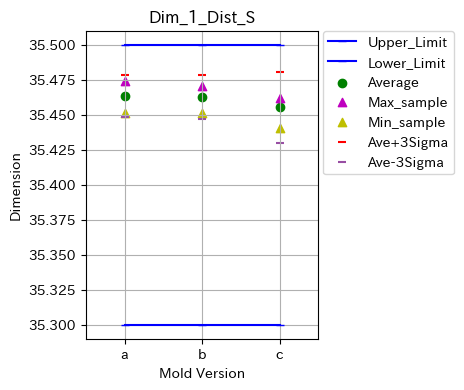

In [440]:
# オブジェクト指向型でプロット
marker_list = ["_", "_", "o", "^", "^", "_", "_"]
color_list =  ["b", "b", "g", "m", "y", "r", '#984ea3']

fig, ax = plt.subplots(figsize=(3,4))

for index, markint, colorint in zip(plot_dfs[0].index,marker_list, color_list):
    if index == "Upper_Limit" or index == "Lower_Limit":
        ax.plot(plot_dfs[0].columns, plot_dfs[0].loc[index],color=colorint, marker=markint, label=index)
    else:
        ax.scatter(x=plot_dfs[0].columns, y=plot_dfs[0].loc[index],color=colorint, marker=markint, label=index)

ax.set_xlabel('Mold Version')
ax.set_ylabel('Dimension')
ax.set_title(columns_marge[0])

ax.set_xticks(range(len(plot_dfs[0].columns)))
ax.set_xticklabels(plot_dfs[0].columns)
ax.set_xlim([-0.5, len(sheet_name_list)-0.5])

ax.legend()
ax.grid(True)
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)

plt.savefig("plt_folder/sample"+f"{i}"+".png", dpi = 600)
plt.show()

In [ ]:
with pd.ExcelWriter("output.xlsx") as writer:
    for i in range(len(export_dfs)):
        export_dfs[i].to_excel(writer,sheet_name=f"{i}")

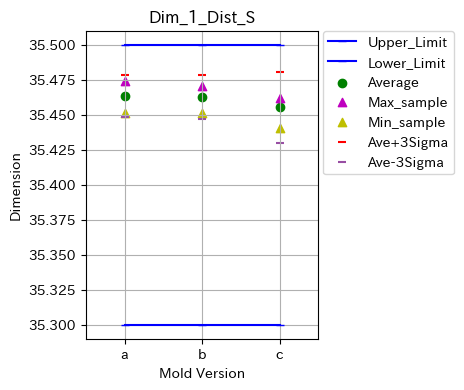

In [442]:
# オブジェクト指向型でプロット
marker_list = ["_", "_", "o", "^", "^", "_", "_"]
color_list =  ["b", "b", "g", "m", "y", "r", '#984ea3']

for df, column_name in zip(plot_dfs, columns_marge):
    fig, ax = plt.subplots(figsize=(3,4))
    for index, markint, colorint in zip(df.index,marker_list, color_list):
        if index == "Upper_Limit" or index == "Lower_Limit":
            ax.plot(df.columns, df.loc[index],color=colorint, marker=markint, label=index)
        else:
            ax.scatter(x=df.columns, y=df.loc[index],color=colorint, marker=markint, label=index)

    ax.set_xlabel('Mold Version')
    ax.set_ylabel('Dimension')
    ax.set_title(column_name)

    ax.set_xticks(range(len(df.columns)))
    ax.set_xticklabels(df.columns)
    ax.set_xlim([-0.5, len(sheet_name_list)-0.5])

    ax.legend()
    ax.grid(True)
    ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0,), borderaxespad=0)

    plt.savefig("plt_folder/sample"+column_name+".png", dpi = 600)
    plt.show()

In [46]:
# 列名のリスト（系列A, 系列B）
column_names = ['系列A', '系列B']

# 使用可能なシート名のリスト
sheet_names = list(all_sheets.keys())

# 各系列に対して散布図を作成
for column_name in column_names:
    # FigureとAxesを作成
    fig, ax = plt.subplots()

    # 使用可能なすべてのシートからデータを抽出してプロット
    for sheet_name in sheet_names:
        df = all_sheets.get(sheet_name)
        if df is not None and column_name in df.columns:
            data = df[column_name]
            ax.scatter([sheet_name]*len(data), data, label=sheet_name)

    # グラフの設定
    ax.set_title(f"Scatter Plot of '{column_name}' in Sheets")
    ax.set_xlabel('Sheet Name')
    ax.set_ylabel(column_name)
    ax.legend()

    # グラフを表示
    plt.show()